In [154]:
import os
import pickle
from IPython.display import display
from PIL import Image
import numpy as np
%matplotlib inline
import matplotlib.pyplot as plt
import random
random.seed(0)
np.random.seed(0)
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from keras.models import Sequential
from keras.layers import Dense, Activation, Flatten
from keras.optimizers import Adadelta
from keras.utils import np_utils
from keras.layers.convolutional import Convolution2D, MaxPooling2D
from keras.utils.visualize_util import model_to_dot, plot
from keras import backend as K
from IPython.display import SVG

In [155]:
def unpickle(filepath):
    with open(filepath, 'rb') as bfile:
        batch = pickle.load(bfile)
        return batch

def prepare_batch(batch):
    return batch['data'], batch['labels']

In [156]:
def load_cifar10_dataset(dataset_path, shuffle=True):
    train_data, train_labels = [], []
    test_data, test_labels = [], []
    meta_path = ''
    for f in os.scandir(dataset_path):
        if f.is_file:
            if 'data_batch' in f.name:
                data, labels = prepare_batch(unpickle(f.path))
                train_data.append(data)
                train_labels.append(labels)
            elif 'test_batch' in f.name:
                data, labels = prepare_batch(unpickle(f.path))
                test_data.append(data)
                test_labels.append(labels)
            elif 'meta' in f.name:
                meta_path = f.path
    print('loaded {0} train batches, {1} test batches'.format(len(train_data), len(test_data)))
    
    meta = unpickle(meta_path)
    label_names = meta['label_names']
    label_idx_to_name = {key: value for key, value in zip(range(len(label_names)), label_names)}

    X_train = np.concatenate(train_data)
    y_train = np.concatenate(train_labels)
    X_test = np.concatenate(test_data)
    y_test = np.concatenate(test_labels)

    if shuffle:
        train_shuffled_idxs = np.arange(X_train.shape[0])
        np.random.shuffle(train_shuffled_idxs)

        X_train = X_train[train_shuffled_idxs]
        y_train = y_train[train_shuffled_idxs]
        
        test_shuffled_idxs = np.arange(X_test.shape[0])
        np.random.shuffle(test_shuffled_idxs)
        X_test = X_test[test_shuffled_idxs]
        y_test = y_test[test_shuffled_idxs]

    return X_train, y_train, X_test, y_test, label_idx_to_name

In [157]:
X_train, y_train, X_test, y_test, label_idx_to_name = load_cifar10_dataset('datasets/cifar-10-batches-py3/')

loaded 5 train batches, 1 test batches


In [158]:
def batch_im_to_PIL(batch_im):
    im = batch_im.reshape(3, 32, 32).transpose(1, 2, 0).astype('uint8')
    return Image.fromarray(im)

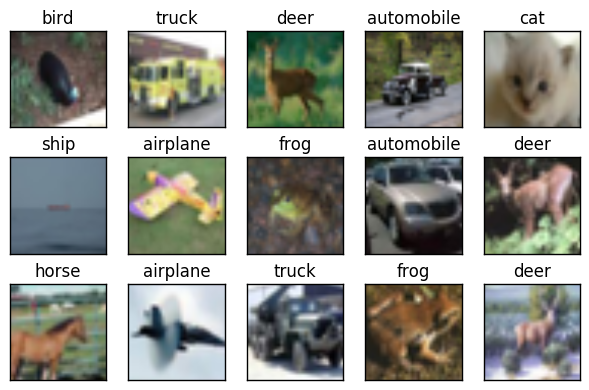

In [159]:
num_plot_rows = 3
num_plot_cols = 5

# Select ids of random images from train dataset.
num_train_samples = X_train.shape[0]
random_ims = random.sample(range(num_train_samples), num_plot_rows * num_plot_cols)

# Prepare plot grid.
_, ax = plt.subplots(num_plot_rows, num_plot_cols)

sample_id = 0
for r in range(num_plot_rows):
    for c in range(num_plot_cols):
        # Hide axes.
        ax[r, c].get_xaxis().set_visible(False)
        ax[r, c].get_yaxis().set_visible(False)
        
        # Show image.
        train_im = batch_im_to_PIL(X_train[sample_id])
        ax[r, c].imshow(train_im)
        
        # Show image class as title.
        label_name = label_idx_to_name[y_train[sample_id]]
        ax[r, c].set_title(label_name)

        sample_id += 1

# Needed to fix overlapping of images and text.
plt.tight_layout()

In [160]:
num_train_samples = 1000
num_test_samples = 200

In [161]:
clf = LogisticRegression()
clf.fit(X_train[:num_train_samples], y_train[:num_train_samples])
print(clf.score(X_test[:num_test_samples], y_test[:num_test_samples]))

0.21


In [162]:
clf = KNeighborsClassifier()
clf.fit(X_train[:num_train_samples], y_train[:num_train_samples])
print(clf.score(X_test[:num_test_samples], y_test[:num_test_samples]))

0.18


In [163]:
from skimage.filters import gabor_kernel
from scipy import ndimage as ndi
def compute_feats(image, kernels):
    feats = np.zeros((len(kernels), 2), dtype=np.double)
    for k, kernel in enumerate(kernels):
        filtered = ndi.convolve(image, kernel, mode='wrap')
        feats[k, 0] = filtered.mean()
        feats[k, 1] = filtered.var()
    return feats

In [164]:
kernels = []
for theta in range(4):
    theta = theta / 4. * np.pi
    for sigma in (1, 3):
        for frequency in (0.05, 0.25):
            kernel = np.real(gabor_kernel(frequency, theta=theta,
                                          sigma_x=sigma, sigma_y=sigma))
            kernels.append(kernel)

In [165]:
print(kernels[1].shape)

(7, 7)


In [166]:
im = batch_im_to_PIL(X_train[0]).convert('L')

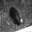

In [167]:
im

In [168]:
filtered = ndi.convolve(im, kernels[2], mode='wrap')

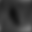

In [169]:
Image.fromarray(filtered)

In [170]:
compute_feats(im, kernels).shape

(16, 2)

In [171]:
feats_train = [compute_feats(batch_im_to_PIL(im).convert('L'), kernels).flatten() for im in X_train[:num_train_samples]]
feats_test = [compute_feats(batch_im_to_PIL(im).convert('L'), kernels).flatten() for im in X_test[:num_test_samples]]

In [172]:
clf = LogisticRegression()
clf.fit(feats_train, y_train[:num_train_samples])
clf.score(feats_test, y_test[:num_test_samples])

0.29999999999999999

In [173]:
from skimage.feature import hog
from skimage import data, color, exposure

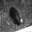

In [174]:
im

In [175]:
hog_feat, hog_im = hog(im, orientations=8, pixels_per_cell=(4, 4), cells_per_block=(4, 4), visualise=True)
hog_image_rescaled = exposure.rescale_intensity(hog_im, in_range=(0, 0.02))

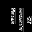

In [176]:
Image.fromarray(hog_im, mode='L')

In [177]:
hog_feats_train = [hog(batch_im_to_PIL(im).convert('L'), orientations=9, pixels_per_cell=(4, 4), cells_per_block=(3, 3), transform_sqrt=True) for im in X_train[:num_train_samples]]
hog_feats_test = [hog(batch_im_to_PIL(im).convert('L'), orientations=9, pixels_per_cell=(4, 4), cells_per_block=(3, 3), transform_sqrt=True) for im in X_test[:num_test_samples]]

In [178]:
clf = LogisticRegression()
clf.fit(hog_feats_train, y_train[:num_train_samples])
clf.score(hog_feats_test, y_test[:num_test_samples])

0.33500000000000002

In [179]:
from skimage.feature import local_binary_pattern

In [180]:
radius = 3
n_points = 8 * radius

In [181]:
lbp_feats_train = [local_binary_pattern(batch_im_to_PIL(im).convert('L'), n_points, radius).ravel() for im in X_train[:num_train_samples]]
lbp_feats_test = [local_binary_pattern(batch_im_to_PIL(im).convert('L'), n_points, radius).ravel() for im in X_test[:num_test_samples]]

In [182]:
clf = LogisticRegression()
clf.fit(lbp_feats_train, y_train[:num_train_samples])
clf.score(lbp_feats_test, y_test[:num_test_samples])

0.105

In [183]:
from skimage.feature import canny

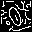

In [184]:
Image.fromarray(canny(np.asarray(im)).astype('uint8')*255)

In [185]:
canny_feats_train = [canny(np.asarray(batch_im_to_PIL(im).convert('L'))).ravel() for im in X_train[:num_train_samples]]
canny_feats_test = [canny(np.asarray(batch_im_to_PIL(im).convert('L'))).ravel() for im in X_test[:num_test_samples]]

In [186]:
clf = LogisticRegression()
clf.fit(canny_feats_train, y_train[:num_train_samples])
clf.score(canny_feats_test, y_test[:num_test_samples])

0.16500000000000001

In [187]:
batch_size = 256
nb_classes = 10
nb_epoch = 4
nb_filter = 10

img_rows, img_cols = 32, 32
img_channels = 3

X_train = X_train.reshape(X_train.shape[0], 3, 32, 32).astype('float32')
X_test = X_test.reshape(X_test.shape[0], 3, 32, 32).astype('float32')
X_train /= 255
X_test /= 255
Y_train = np_utils.to_categorical(y_train, nb_classes)
Y_test = np_utils.to_categorical(y_test, nb_classes)

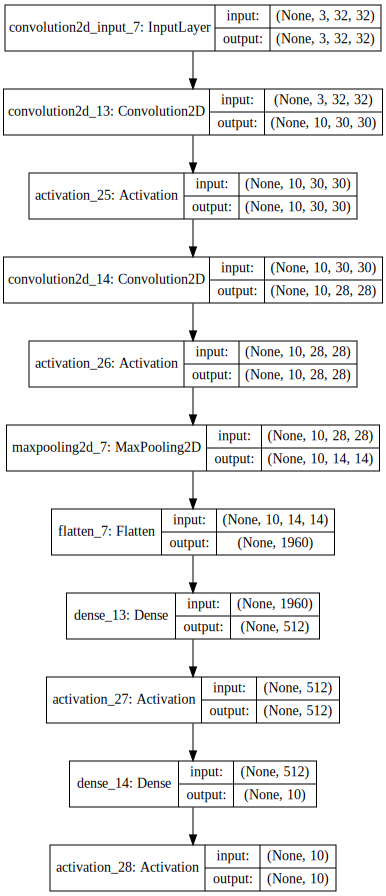

In [188]:
model = Sequential()
model.add(Convolution2D(nb_filter, 3, 3, input_shape=(img_channels, img_rows, img_cols)))
model.add(Activation('relu'))
model.add(Convolution2D(nb_filter, 3, 3))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Flatten())
model.add(Dense(512))
model.add(Activation('relu'))
model.add(Dense(nb_classes))
model.add(Activation('softmax'))

model.compile(loss='categorical_crossentropy',
              optimizer='adadelta',
              metrics=['accuracy'])

SVG(model_to_dot(model, show_shapes=True).create(prog='dot', format='svg'))

In [189]:
res = model.fit(X_train, Y_train, batch_size=batch_size, nb_epoch=nb_epoch, validation_data=(X_test, Y_test))

Train on 50000 samples, validate on 10000 samples
Epoch 1/4
50000/50000 [==============================] - 69s - loss: 1.9065 - acc: 0.3171 - val_loss: 1.6417 - val_acc: 0.4243
Epoch 2/4
50000/50000 [==============================] - 68s - loss: 1.5052 - acc: 0.4718 - val_loss: 1.3951 - val_acc: 0.5103
Epoch 3/4
50000/50000 [==============================] - 68s - loss: 1.3203 - acc: 0.5387 - val_loss: 1.4160 - val_acc: 0.4818
Epoch 4/4
50000/50000 [==============================] - 69s - loss: 1.2005 - acc: 0.5799 - val_loss: 1.2612 - val_acc: 0.5425


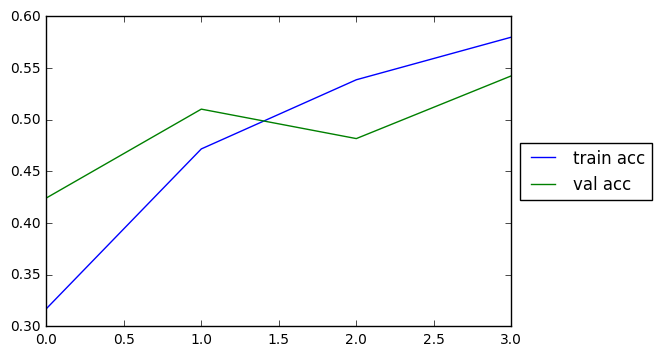

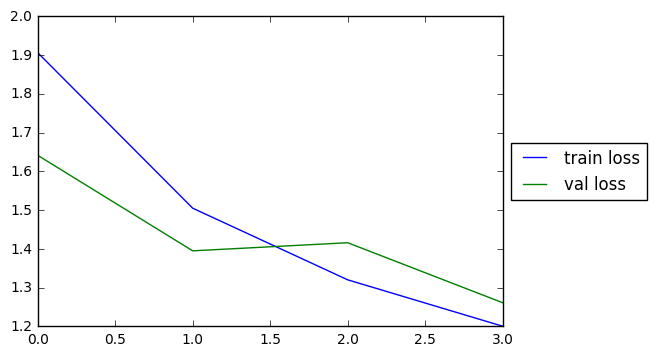

In [190]:
x = range(nb_epoch)
plt.plot(x, res.history['acc'], label="train acc")
plt.plot(x, res.history['val_acc'], label="val acc")
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.show()

plt.plot(x, res.history['loss'], label="train loss")
plt.plot(x, res.history['val_loss'], label="val loss")
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))

In [191]:
def draw(data, row, col, n):
    plt.subplot(row, col, n)    
    plt.imshow(data)

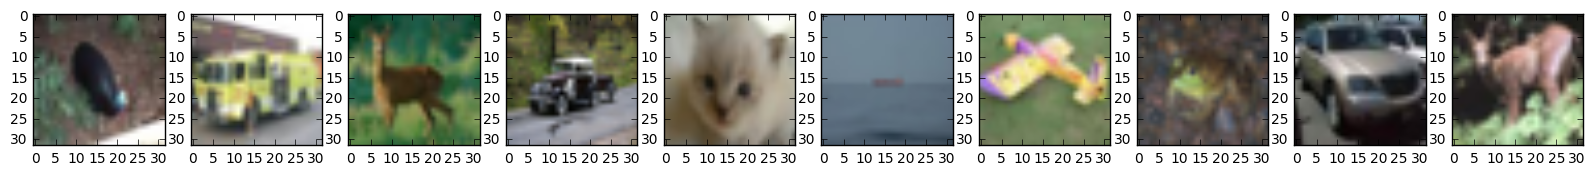

In [192]:
show_size = 10
plt.figure(figsize=(20,20))
for i in range(show_size):
    draw(X_train[i].reshape(3, 32, 32).transpose(1, 2, 0), 1, show_size, i+1)
plt.show()

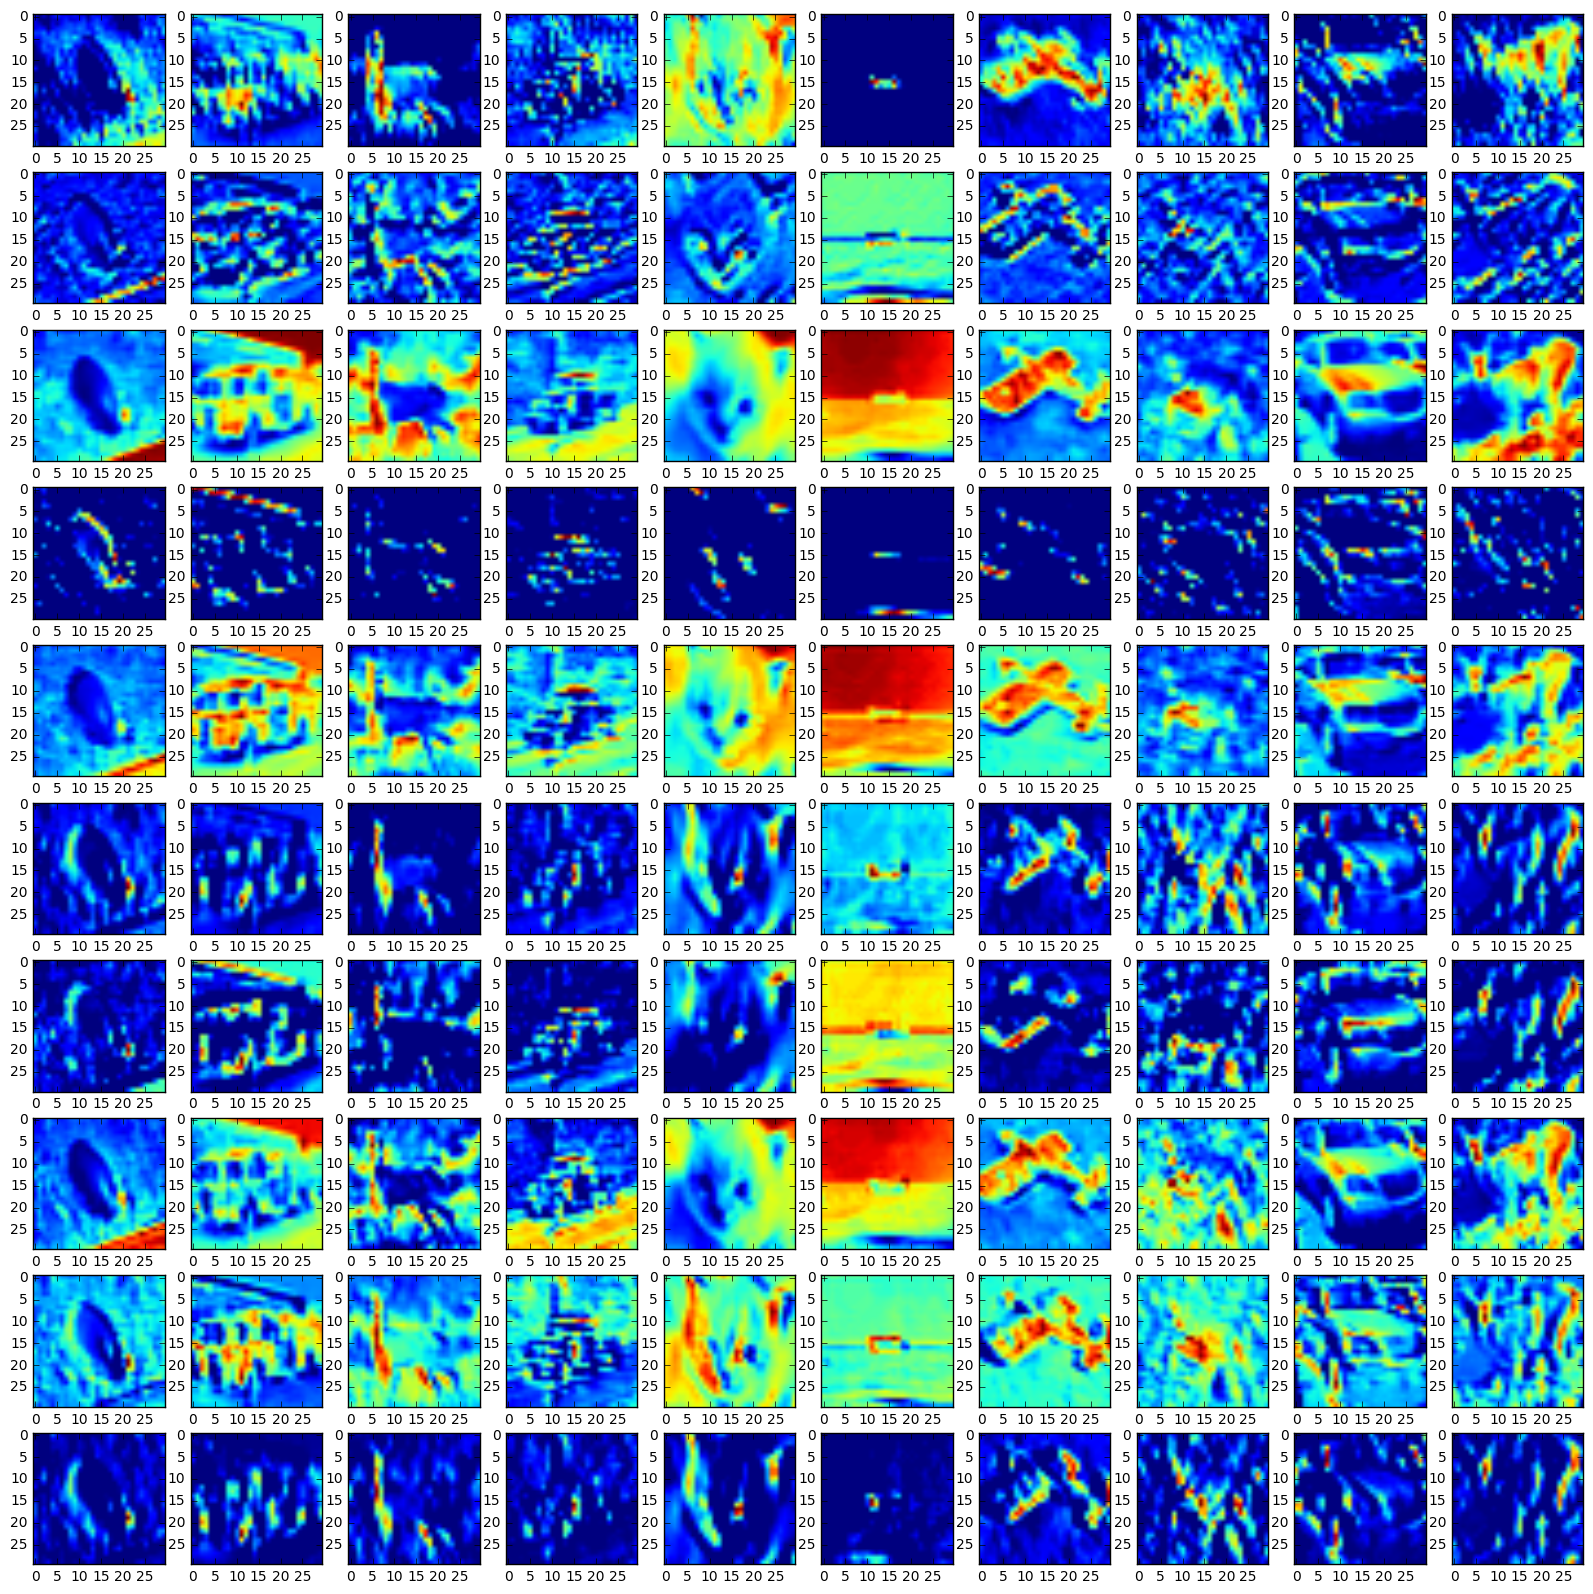

In [193]:
layer_output = K.function([model.layers[0].input],
                          [model.layers[1].output])
layers = layer_output([X_train[0:show_size]])[0]

plt.figure(figsize=(20,20))

for img_index, filters in enumerate(layers, start=1):
    for filter_index, mat in enumerate(filters):
        pos = (filter_index)*show_size+img_index
        draw(mat, nb_filter, show_size, pos)
plt.show()

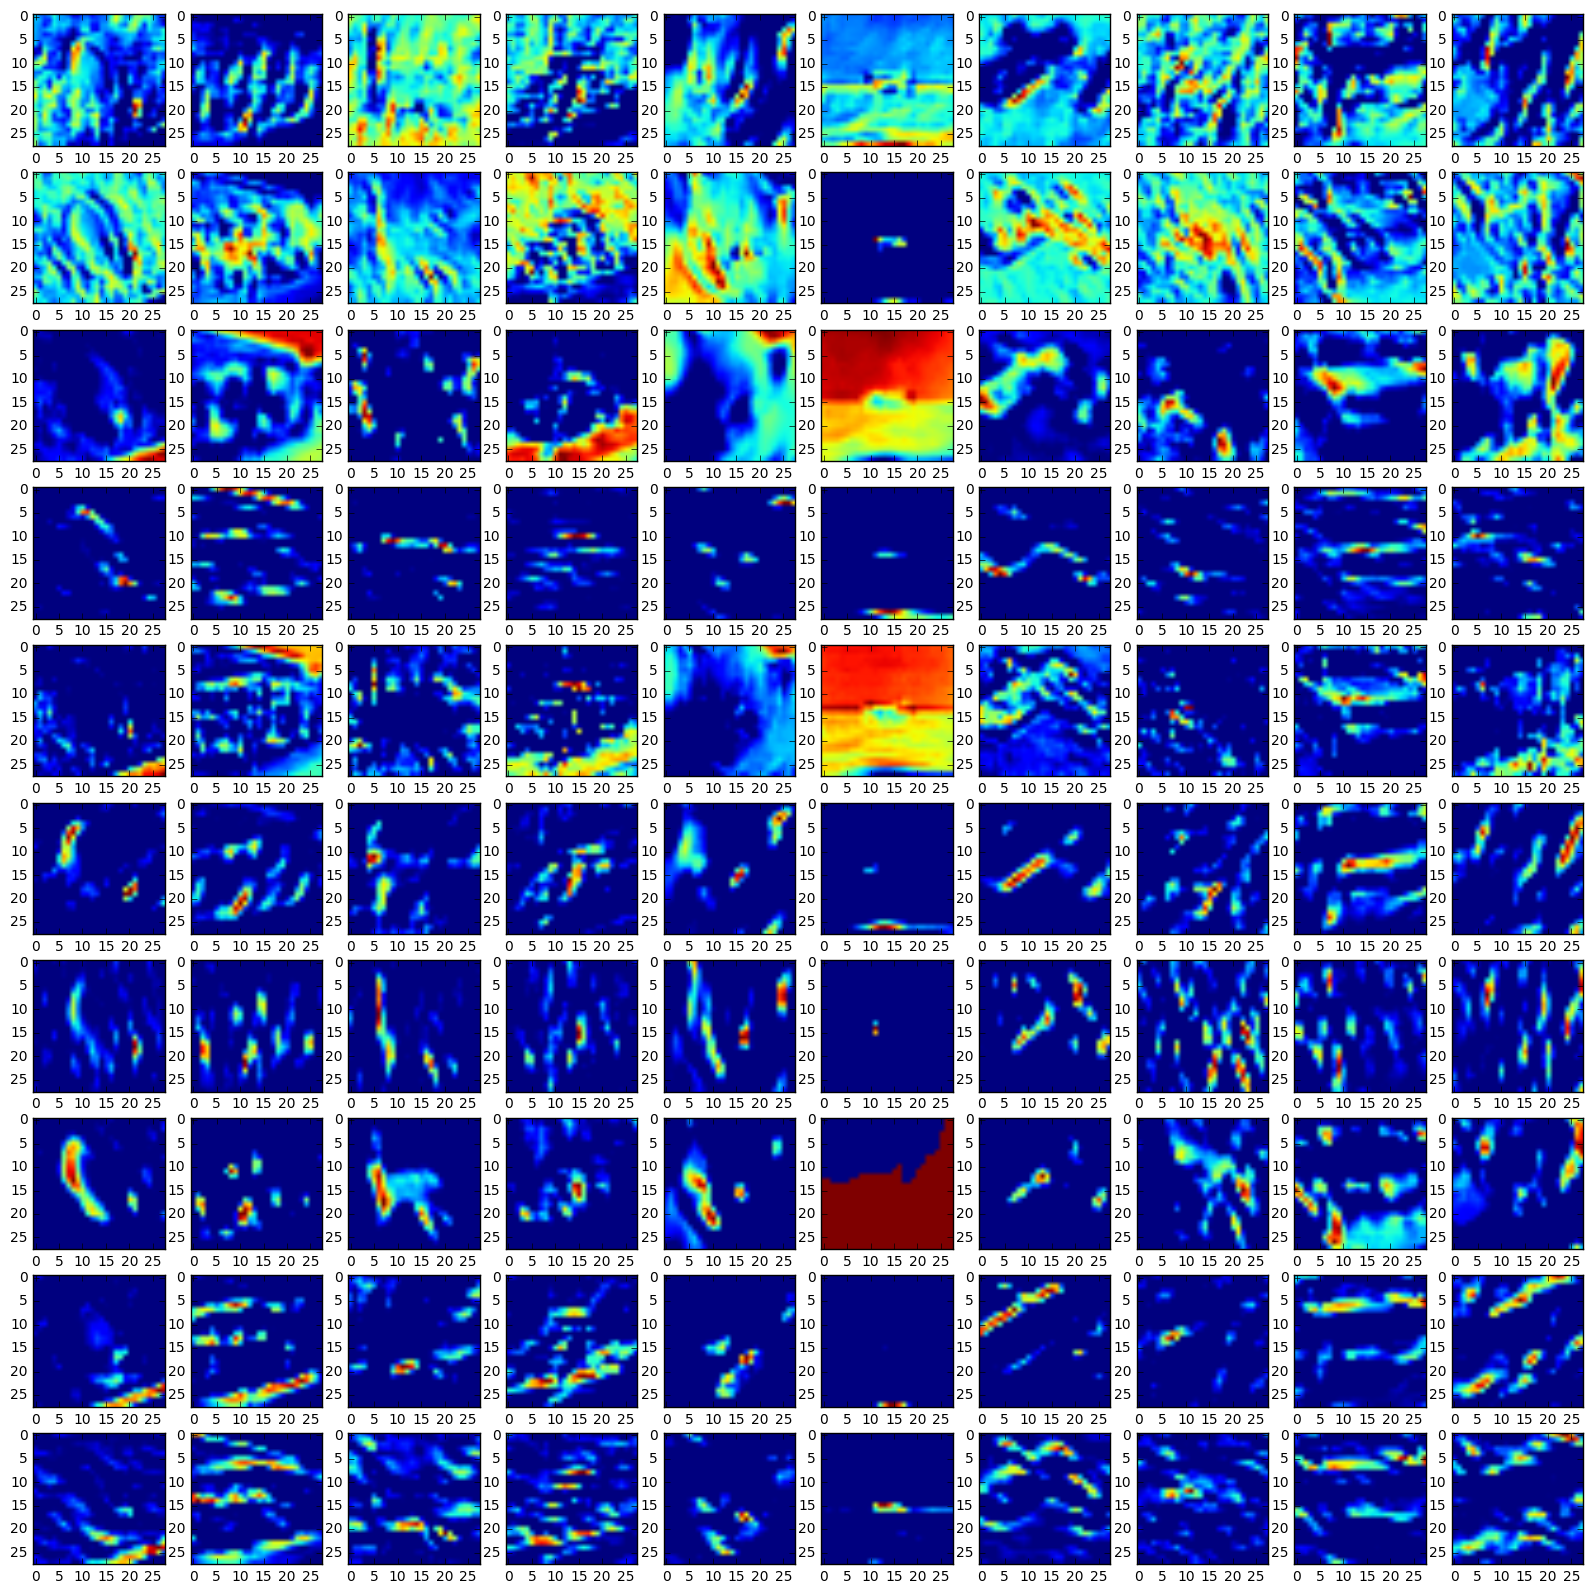

In [195]:
layer_output = K.function([model.layers[0].input],
                          [model.layers[3].output])
layers = layer_output([X_train[0:show_size]])[0]

plt.figure(figsize=(20,20))

for img_index, filters in enumerate(layers, start=1):
    for filter_index, mat in enumerate(filters):
        pos = (filter_index)*show_size+img_index
        draw(mat, nb_filter, show_size, pos)
plt.show()

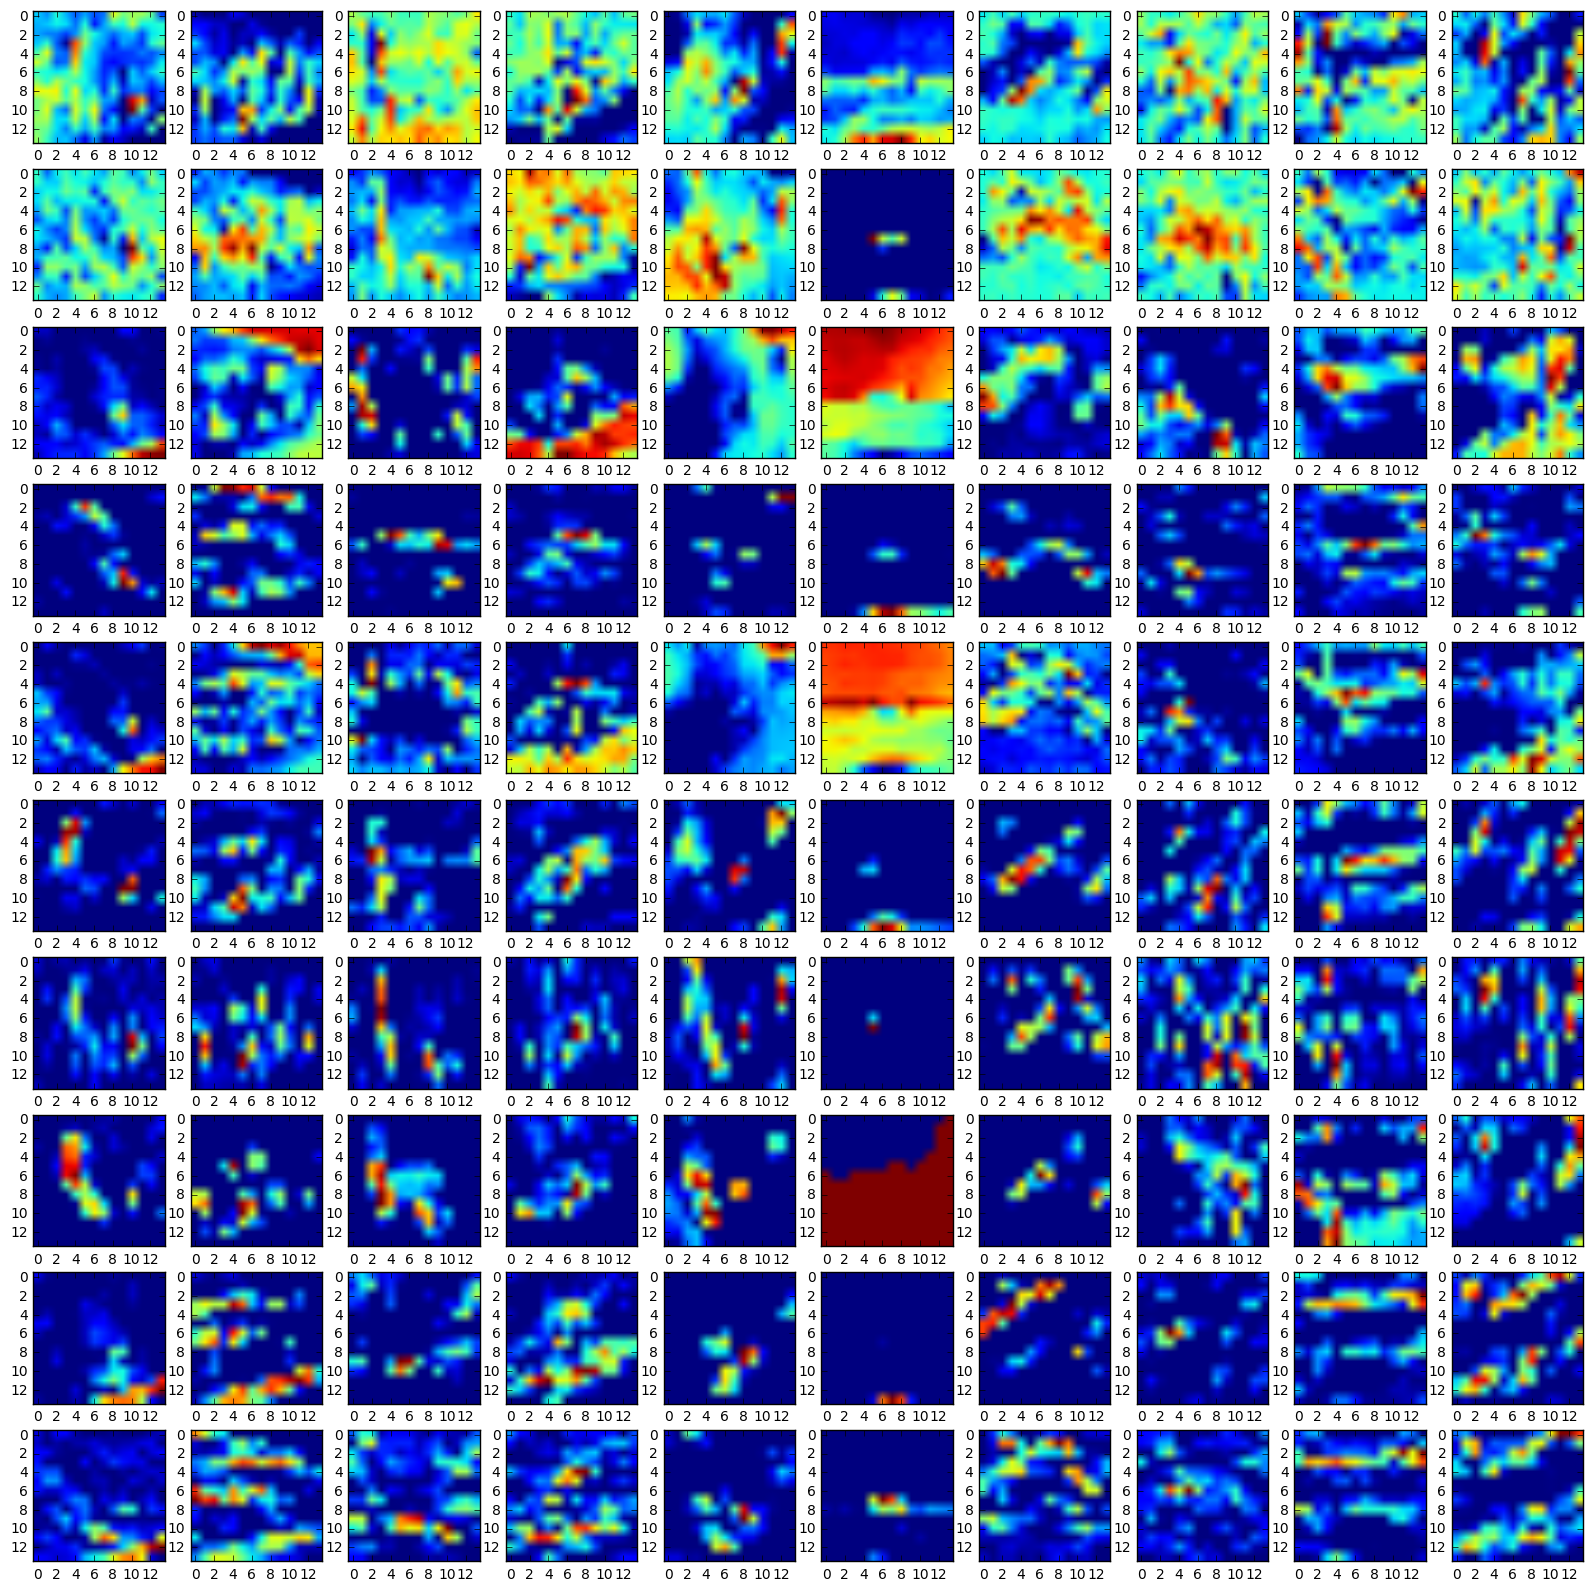

In [196]:
layer_output = K.function([model.layers[0].input],
                          [model.layers[4].output])
layers = layer_output([X_train[0:show_size]])[0]

plt.figure(figsize=(20,20))

for img_index, filters in enumerate(layers, start=1):
    for filter_index, mat in enumerate(filters):
        pos = (filter_index)*show_size+img_index
        mat_size = mat.shape[1]
        draw(mat, nb_filter, show_size, pos)
plt.show()